In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare
from pandas.plotting import register_matplotlib_converters

![Rover logo](../images/rover.png)

## Analysis of the Rover pet sitting database
Instructions are giving in the [Instructions file](../instructions.pdf) in the main directory.

The following tables are available:

In [2]:
! ls ../data

conversations_conversation.csv	     people_person.csv
conversations_conversation_pets.csv  people_testsegmentation.csv
conversations_message.csv	     pets_pet.csv
conversations_review.csv	     services_service.csv


In [3]:
# get data
conversation = pd.read_csv("../data/conversations_conversation.csv")
conversation_pets = pd.read_csv("../data/conversations_conversation_pets.csv")
conversation_message = pd.read_csv("../data/conversations_message.csv")
conversation_review = pd.read_csv("../data/conversations_review.csv")
person = pd.read_csv("../data/people_person.csv")
testsegment = pd.read_csv("../data/people_testsegmentation.csv")
pet = pd.read_csv("../data/pets_pet.csv")
service = pd.read_csv("../data/services_service.csv")

data = [conversation, conversation_pets, conversation_message, conversation_review, person, testsegment, pet, service]

for d in data:
    print(d.head())
    print(d.info())

   id  start_date    end_date  units                       added  \
0   1  2018-07-26  2018-07-31      5  2018-07-16 10:17:53.460035   
1   2  2018-08-10  2018-08-16      6  2018-08-01 10:20:48.626868   
2   3  2018-06-16  2018-06-19      3  2018-06-05 16:46:39.542467   
3   4  2018-07-13  2018-07-20      7  2018-07-02 09:12:22.275923   
4   5  2018-07-02  2018-07-07      5  2018-06-21 16:02:48.694725   

   booking_total cancellation_fault  requester_id  service_id booked_at  \
0            120                NaN         64393        4646       NaN   
1            132                NaN         64392       10126       NaN   
2            168                NaN         64391       20677       NaN   
3            490                NaN         64391        3847       NaN   
4            140                NaN         64389        9982       NaN   

  cancelled_at  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
<class 'pandas.core.frame.DataFrame'>


## 1. Exploring the database

* How many users are there?
* How many users signed on prior to 2018-02-03?
* What percentage of users have pets?
* Of those users, how many pets have they added on average?
* What percentage of pets play well with cats?

In [4]:
num_people = person.id.nunique()
mask = person.date_joined < '2018-02-03'
num_pets = pet.id.nunique()
num_people_w_pets = pet.owner_id.nunique()
num_pets_liking_cats = sum(pet.plays_cats)

#users
print(f" There are {num_people} users, of which {person[mask]['id'].nunique()} joined before 2018-02-03.")

# percentage of users with pets
print(f"{round((num_people_w_pets/num_people)*100, 2)}% of users have pets")

#ave number of pets per user
print(f"There are {round(num_pets/num_people_w_pets, 2)} pets per user")

#%pets that play well with cats
print(f"{(round((num_pets_liking_cats/num_pets)*100, 2))} percent of pets play well with cats")

 There are 64393 users, of which 35826 joined before 2018-02-03.
80.43% of users have pets
There are 1.5 pets per user
24.85 percent of pets play well with cats


## 2. Conversations and bookings


Some users can offer pet care services. When an owner needs pet care, they can
create a conversation with another user that offers the service they are interested in.
After exchanging some messages and possibly meeting in person, that conversation
hopefully books. In that case, services are paid for and delivered. Occasionally, some
conversations that have booked may be cancelled. Lastly, for uncancelled bookings,
both owners and sitters have the option of leaving a review. In the following
questions, we explore these concepts.  

**Question:** For uncancelled bookings, is the owner or provider more likely to leave a review
and which tends to leave better reviews? How would you narrate this finding to a
business partner?


In [5]:
# get all booked, non-cancelled services with requester and provider ids
booked_service = conversation[(conversation.booked_at.notnull())& (conversation.cancelled_at.isna())]
b2 = booked_service.merge(service[['id', 'provider_id']], left_on = "service_id", right_on = "id")
b2.drop_duplicates(subset = "id_x", inplace = True)
unique_providers = b2.provider_id.nunique()
unique_requesters = b2.requester_id.nunique()
print("Number of unique providers:", unique_providers)
print("Number of unique requesters:", unique_requesters)

Number of unique providers: 8927
Number of unique requesters: 23099


In [6]:
# get relative frequency of reviews
providers = conversation_review.merge(b2["provider_id"], right_on = "provider_id", left_on = "reviewer_id", how = "inner")
requesters = conversation_review.merge(b2["requester_id"], right_on = "requester_id", left_on = "reviewer_id", how = "inner")
providers.drop_duplicates(subset = "id", inplace=True)
requesters.drop_duplicates(subset = "id", inplace=True)

num_reviews = len(conversation_review)
num_providers = len(providers)
num_requesters = len(requesters)

num_unique_providers_reviewing = providers.provider_id.nunique()
num_unique_requesters_reviewing = requesters.requester_id.nunique()

print(f"providers = {num_providers} ({round(num_providers/num_reviews*100, 1)}% of total reviews)")
print(f"requesters = {num_requesters} ({round(num_requesters/num_reviews*100, 1)}% of total reviews)")
print(f"unique provider reviews = \
{num_unique_providers_reviewing} ({round(num_unique_providers_reviewing/unique_providers*100,1)}% of providers)")
print(f"unique requester reviews = {num_unique_requesters_reviewing} \
({round(num_unique_requesters_reviewing/unique_requesters*100, 1)} % of requesters)")
print(f"total_reviews = {num_reviews}")

providers = 6062 (21.2% of total reviews)
requesters = 22499 (78.8% of total reviews)
unique provider reviews = 4062 (45.5% of providers)
unique requester reviews = 18358 (79.5 % of requesters)
total_reviews = 28561


There are definitely more requesters leaving reviews than providers, but there are also far more requesters than providers in total. Let's look at the proportion of unique provider reviews to all unique providers booked, and the same for unique requesters.

In [7]:
chi, p, table = proportions_chisquare(
    [num_unique_providers_reviewing, num_unique_requesters_reviewing], 
    [unique_providers, unique_requesters])

print(f"chi squared: {chi}, p-value {p}")
table

chi squared: 3539.0630404071817, p-value 0.0


(array([[ 4062,  4865],
        [18358,  4741]]),
 array([[ 6249.40173609,  2677.59826391],
        [16170.59826391,  6928.40173609]]))

**Only half of providers have a left at least one review, whereas nearly 80% of requesters have left at least one review.** As shown from the chi-squared test above, there is a significant difference in the proportion of reviews provided. Next, I'll look at who is more likely to leave better reviews.

In [8]:
print(f"Provider ratings: mean = {providers.stars.mean()}, sd = {providers.stars.std()}")
print(f"(Requester ratings: mean = {requesters.stars.mean()}, sd = {requesters.stars.std()}")

t, p, df = ttest_ind(
    providers.stars, requesters.stars, 
    alternative = "two-sided", 
    usevar = "pooled")

print (t, df, p)

Provider ratings: mean = 3.9048168921148134, sd = 1.446287360330038
(Requester ratings: mean = 4.41584070403129, sd = 1.1873820713457532
-28.322812368207458 28559.0 4.6266026283482415e-174


**Requesters give a significantly higher star rating than providers. Requesters on average five a 4.4 star rating compared to providers' 3.9 star average rating.**

## 3. Booking trend

The snapshot of this database was taken on 2018-08-02 at midnight and only
contains data reflecting events prior to that date. A junior analyst is investigating
daily booking rate during the days prior to the snapshot and is concerned about an
apparent downward trend. You are tasked with helping them out.   

**Questions/ Instructions**: First, reproduce their results. They tell you that daily booking rate is defined
to be the percentage of conversations created each day that eventually book.
What is the daily booking rate for each of the 90 days prior to the snapshot? Is
there a downward trend?  

Can you narrate a reason why this trend exists? Is there a reason to be
concerned? Please provide additional data and evidence to justify your position.


In [9]:
# conversation.added is date of conversation start
# conversation.booked_at gives timestamp if booked

# aggregate by day, calculate percentage booked of total
def percentage_booked(conversation):
    booking_ratio = len(conversation[conversation.booked_at.notnull()])/len(conversation)
    return round(booking_ratio*100, 3)

def get_day(conversation):
    conversation["added"] = pd.to_datetime(conversation.added)
    conversation["day_added"] = conversation.added.dt.date

def booking_rate_df(conversation):
    ''' Returns df with number of conversations, number of bookings, and booking rate per day. Index is the date'''
    booking_rate = conversation.groupby("day_added").count()[["added", "booked_at"]].copy()
    booking_rate["rate"] = booking_rate["booked_at"]/booking_rate["added"]*100
    return booking_rate
    
get_day(conversation)
print(f"Percentage of conversations leading to a booking: {percentage_booked(conversation)}")
booking_rate = booking_rate_df(conversation)
last_90_days = booking_rate[-90:]


Percentage of conversations leading to a booking: 41.739


In [10]:
last_90_days["rate"].describe()

count    90.000000
mean     42.665635
std       6.772030
min       4.929577
25%      41.362503
50%      43.757610
75%      45.777778
max      51.893939
Name: rate, dtype: float64

The mean daily booking rate is 42.67% for the last 90 days (SD  = 6.77). We see that for the last 5 or so days the daily rate has been much lower, falling under the 25th percentile:

In [11]:
print("Booking rate for last 10 days:")
last_90_days["rate"][-10:]

Booking rate for last 10 days:


day_added
2018-07-23    49.822064
2018-07-24    44.981413
2018-07-25    46.048110
2018-07-26    39.575972
2018-07-27    43.508772
2018-07-28    38.064516
2018-07-29    31.086142
2018-07-30    18.750000
2018-07-31    12.418301
2018-08-01     4.929577
Name: rate, dtype: float64

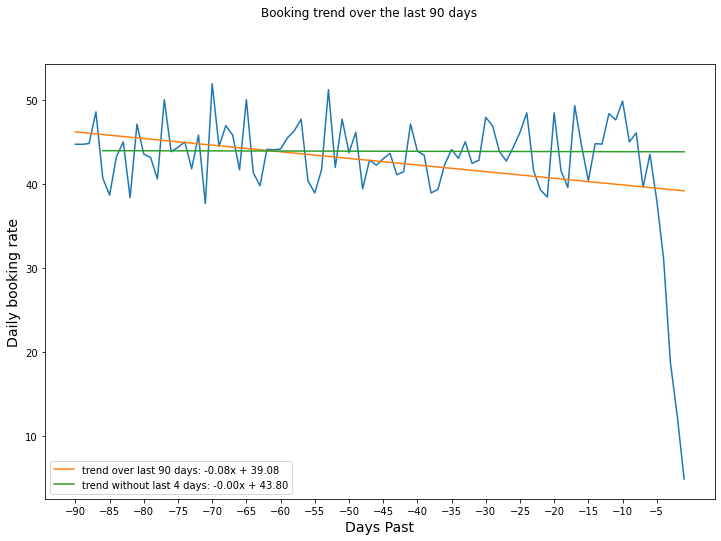

In [14]:
#keep datetime consistent between pandas and matplotlib
register_matplotlib_converters()

def create_reg_params(y):
    x = np.arange(-len(y),0)
    m, b = np.polyfit(x, y, 1)
    return x,m,b

def create_trendplot(fig, ax):
    x1, m1, b1 = create_reg_params(last_90_days["rate"])
    x2, m2, b2 = create_reg_params(last_90_days["rate"][:-4])

    fig.suptitle("Booking trend over the last 90 days")
    
    ax.set_xlabel("Days Past", size = 14)
    ax.set_ylabel("Daily booking rate", size = 14)
    ax.set_xticks(np.arange(-90,0,5))
    
    ax.plot(x1, last_90_days.rate);
    ax.plot(x1, x1*m1 + b1, label = "trend over last 90 days: %.2fx + %.2f" %(m1,b1))
    ax.plot(x2, x2*m2+b2, label = "trend without last 4 days: %.2fx + %.2f" %(m2,b2))
    
    ax.legend()
    fig.show();

fig, ax = plt.subplots(figsize = (12,8))
create_trendplot(fig, ax)
# calculate ave time to book

There is a negative trend over the last 90 days (the orange line). It looks like this is because daily booking has dropped sharply over the last few days, but I suspect it's because users take many days to book. In fact, if we remove the last 5 days from the trend line calculation (the green line), then the booking rate remains constant.

Let's investigate the average time it takes between starting a conversation and booking.

In [15]:
def time_taken_to_book(conversation):
    conversation["booked_at"] = pd.to_datetime(conversation.booked_at)
    conversation["time_to_booking"] = conversation["booked_at"] - conversation["added"]

time_taken_to_book(conversation)
conversation["time_to_booking"].describe()

count                        33466
mean     3 days 04:12:51.861342011
std      1 days 18:49:29.653754783
min         0 days 00:15:54.006844
25%      1 days 19:10:27.733077250
50%      2 days 22:16:06.020834500
75%         4 days 07:20:02.210654
max        11 days 00:47:33.190898
Name: time_to_booking, dtype: object

Indeed, on average it takes 3 days and 4 hours before a conversation leads to a booking. The maximum time in our dataset was 11 days, and 75% of bookings occur within 4 days and 7 hours. **The downward trend in the last 4-5 days that we see here is probably just because the users who started conversations in the last few days have not yet had a chance to book.** 


## 4. Take rate

For the next section, here are the details of the fee structure for this
company. Each user has a fee associated with their account (recorded on
`people_person`). If that user books as an owner, the company charges a service fee
(in addition to the booking total) that is a percentage of the booking total (to a
maximum of 50 USD). Also, each service has a fee amount (recorded on
`services_service`). Before a provider receives their payment, the company takes a
percentage of the booking total as dictated by that fee.  

As an example, suppose an
owner has a fee amount of 5% and books with a service that has a fee amount of
15%. If the booking was for 100 USD, then the owner would get charged 105 USD (adding
the ownerʼs fee). The 5 USD owner fee would go to the company. An additional 15 USD
would also go to the company since the service had a 15% fee associated to it. 

**Questions**:
We want to investigate the take rate (net revenue / gross billings). We'll answer the following questions:
- In each month, what were the gross billings and net revenue?
- What was the aggregate take rate per month?
- If the take rate changed, why did it change?

### Approach

First we can calculate the different fees and the net revenue. The calculation details come from the instruction document. We'll need to get the services that were booked (and not cancelled) from the conversation table and join the relevant fields to the fees in the service table.

**Note:** Different cancellation policies are given within the service table (moderate, strict, etc), but no information is given in the instruction on how these cancellation policies influence the amount that is refunded when someone cancels. For example, a last minute cancellation may result in no refund. Without the refund information, we'll assume that users were refunded in full if they cancelled and we will not add fees for those bookings to the net revenue or gross billings. Note that this is likely an underestimate of the company's net revenue and gross billings.

In [16]:
def calculate_revenue_and_payment(service):
    owner_fee_percentage = 0.05
    service["owner_fee"] = service["price"]*owner_fee_percentage
    service["gross_billing"] = service["price"] + service["owner_fee"]
    service["service_fee"] = service["price"]*service["fee"]
    service["net_revenue"] = service["owner_fee"] + service["service_fee"]
    service["provider_payment"] = service["gross_billing"] - service["net_revenue"]
    return service

calculate_revenue_and_payment(service)
service.head()

,id,service_type,cancellation_policy,can_provide_oral_medication,can_provide_injected_medication,senior_dog_experience,special_needs_experience,takes_small_dogs,takes_medium_dogs,takes_large_dogs,...,max_dogs,provider_id,fee,price,added,owner_fee,gross_billing,service_fee,net_revenue,provider_payment
0,1,boarding,strict,1,1,1,1,0,1,1,...,4,1,0.15,35,2016-08-02 14:59:15.095591,1.75,36.75,5.25,7.0,29.75
1,2,dog-walking,strict,1,0,1,1,0,0,1,...,5,1,0.15,26,2016-08-02 14:59:15.095591,1.30,27.30,3.90,5.2,22.10
2,3,boarding,moderate,0,0,1,0,0,0,1,...,2,2,0.15,31,2016-08-02 18:15:30.105940,1.55,32.55,4.65,6.2,26.35
3,4,dog-walking,strict,1,0,1,0,1,0,0,...,5,2,0.15,27,2016-08-02 18:15:30.105940,1.35,28.35,4.05,5.4,22.95
4,5,day-care,strict,1,0,1,1,0,1,1,...,5,2,0.15,30,2016-08-02 18:15:30.105940,1.50,31.50,4.50,6.0,25.50


Then, we want to get the total net revenue and gross billings per month, which means that we need to extract month from the date.

In [17]:
def get_revenue_table(conversation, service):
    ''' Returns revenue table with relevant columns from conversation and service tables, joined on service_id'''
    # get services booked and their date
    relevant_cols = ["requester_id", "service_id", "booked_at", "cancelled_at"]
    booked_services = conversation.loc[conversation.booked_at.notnull(), relevant_cols]
    booked_not_cancelled = booked_services[booked_services.cancelled_at.isnull()]

    # map to price for service
    revenue = booked_not_cancelled.merge(service, how = "left", left_on = "service_id", right_on = "id")
    revenue.head()

    #get year & month
    revenue["booked_month"] = revenue.booked_at.dt.to_period('M')

    revenue_cols = ["service_id", "requester_id", "provider_id", "booked_at", "booked_month", "service_type", 
                    "cancellation_policy", "price", "fee", "owner_fee", "gross_billing", "service_fee", "net_revenue", "provider_payment"]
    return revenue[revenue_cols]

def sum_by_month(revenue, col):
    ''' Returns sum of col values by month'''
    return revenue.groupby("booked_month")[col].apply(lambda x: x.sum())


revenue = get_revenue_table(conversation, service)
financial_cols = ["net_revenue", "gross_billing"]
monthly_vals = []

for col in financial_cols:
    monthly_vals.append(sum_by_month(revenue, col))

monthly_data = pd.concat(monthly_vals, axis = 1)
monthly_data

,net_revenue,gross_billing
booked_month,,
2016-08,101.40,532.35
2016-09,471.20,2473.80
2016-10,808.20,4243.05
2016-11,1228.80,6451.20
2016-12,1552.60,8151.15
2017-01,2048.00,10752.00
2017-02,2309.40,12124.35
2017-03,3386.00,17776.50
2017-04,3631.00,19062.75


**Gross billing and net revenue have been growing month-over-month since 2016.** Note that August 2018 represents only two days worth of data. August 2016 was also not a full month - service bookings start on August 13th.

In [18]:
print(f"Start date: {revenue.booked_at.min()}")
print(f"End date: {revenue.booked_at.max()}")

Start date: 2016-08-13 11:01:09.094354
End date: 2018-08-02 10:17:16.280293


Next, we'll look at the average take rate per month. We can see that the take rate has increased from 19% in the first year to 23% in the third year.

In [19]:
def get_take_rate(revenue):
    return revenue["net_revenue"]/revenue["gross_billing"]

def calculate_monthly_average(revenue, col):
    return revenue.groupby("booked_month")[col].apply(lambda x: x.mean())

#get average take rate by month
revenue["take_rate"] = get_take_rate(revenue)
calculate_monthly_average(revenue, "take_rate")

booked_month
2016-08    0.190476
2016-09    0.190476
2016-10    0.190476
2016-11    0.190476
2016-12    0.190476
2017-01    0.190476
2017-02    0.190476
2017-03    0.190476
2017-04    0.190476
2017-05    0.190780
2017-06    0.196100
2017-07    0.204035
2017-08    0.207830
2017-09    0.215645
2017-10    0.216526
2017-11    0.218838
2017-12    0.220620
2018-01    0.223770
2018-02    0.224751
2018-03    0.225526
2018-04    0.227825
2018-05    0.228178
2018-06    0.229406
2018-07    0.229751
2018-08    0.231554
Freq: M, Name: take_rate, dtype: float64

**Why has take rate changed?** Let's look at individual costs over time.

In [ ]:
billing_cols = ["fee", "owner_fee", "service_fee", "provider_payment", "take_rate"]
monthly_averages = []

for col in billing_cols:
    monthly_averages.append(calculate_monthly_average(revenue, col))

monthly_average_df = pd.concat(monthly_averages, axis = 1)
print(monthly_average_df.head())
print(monthly_average_df.tail())

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Changes in billing structure and fees")
x = np.arange(len(monthly_average_df.index))
for col in billing_cols:
    ax.plot(x, monthly_average_df[col], label = col)

ax.legend()
ax.set_ylabel("USD")
# ax.set_xticks(monthly_average_df.index)

**We can see that fee rate has increased from 15% to 19%, and hence the overall service fees have increased.** This is likely the cause of the increasing take rates. We can calculate a correlation coefficient to test this hypothesis.

In [ ]:
from scipy.stats import pearsonr
pearsonr(monthly_average_df.take_rate, monthly_average_df.fee)

There is a very strong positive correlation between take rate and fee rate (r = 0.99, p < 0.001).